In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from torchvision.models import ResNet18_Weights, resnet18
from tqdm.notebook import tqdm_notebook
from torchvision import datasets, transforms

from src.imagenet_x.evaluate import ImageNetX, get_vanilla_transform
from src.imagenet_x import FACTORS, plots

/home/juliu/anaconda3/envs/bach/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
imagenet_val_path = '../data/ImageNetVal'
transforms = get_vanilla_transform()
dataset = ImageNetX(imagenet_val_path, transform=transforms)    

In [3]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [7]:
dataset[4800]

(tensor([[[-1.3987, -1.4500, -1.4158,  ..., -1.2788, -1.0904, -1.0904],
          [-1.3473, -1.3987, -1.3473,  ..., -1.2103, -1.1932, -1.0733],
          [-1.4843, -1.5699, -1.4843,  ..., -1.0219, -1.1589, -1.0562],
          ...,
          [-0.9020, -0.8335, -0.7308,  ..., -0.6965, -0.9020, -1.0562],
          [-0.7479, -0.6965, -0.6452,  ..., -0.5253, -0.6794, -0.7993],
          [-0.8678, -0.5938, -0.4739,  ..., -0.5767, -0.9020, -0.8164]],
 
         [[-1.2304, -1.2304, -1.1429,  ..., -0.7927, -0.9153, -0.9678],
          [-1.3004, -1.2829, -1.1604,  ..., -0.8627, -0.9503, -0.9328],
          [-1.1429, -1.1954, -1.1779,  ..., -0.8978, -0.9503, -0.8452],
          ...,
          [-0.8978, -0.7402, -0.8452,  ..., -0.4951, -0.8102, -1.2654],
          [-0.7752, -0.7752, -0.7752,  ..., -0.5301, -0.7402, -0.9153],
          [-0.9853, -0.7402, -0.6352,  ..., -0.6352, -1.0378, -0.9328]],
 
         [[-0.9678, -0.9330, -0.8458,  ..., -0.6367, -0.5321, -0.6018],
          [-0.8458, -0.9330,

In [93]:
# Load the model
#Default ResNet18.
modelname= 'resnet18'
model = resnet18(weights=ResNet18_Weights.DEFAULT)

#Dino VIT:
#model = torch.hub.load('facebookresearch/dino:main', 'dino_vitb8')


device = 0
batch_size = 128
num_workers = 4
# Evaluate model on ImageNetX using simple loop
model.eval()
model.to(device)
loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=True,
)
names = loader.dataset.samples

In [4]:
preds = []
probs = []

correct = 0
total = 0
with torch.no_grad():
    for data, target, annotations in loader:
        data, target = data.to(device), target.to(device)
        annotations = annotations.to(device)
        output = model(data)
        pred = output.argmax(dim=1)
        prob = output.softmax(dim=1)
        top_p = prob.topk(1, dim=1)[0]
        mask = pred.eq(target.view_as(pred)).to(device)
        correct += annotations[mask,:].to(device).sum(dim=0)
        total += annotations.to(dtype=torch.int).sum(dim=0)
        preds.append(pred.cpu())
        probs.append(top_p.cpu())

In [18]:
preds1 = torch.cat(preds).numpy()
probs1 = torch.cat(probs).numpy()

In [92]:
namesdf = pd.DataFrame(names, columns=['name', 'index'])
namesdf['name'] = namesdf['name'].str.split('/', expand=True)[6].T
namesdf = namesdf.drop(columns=['index'])
df = pd.DataFrame([preds1, probs1], index=['pred', 'probs']).T
df['probs'] = df['probs'].astype(float)
df = pd.concat([namesdf, df], axis=1)

df.to_csv(modelname+'.csv', index=False)

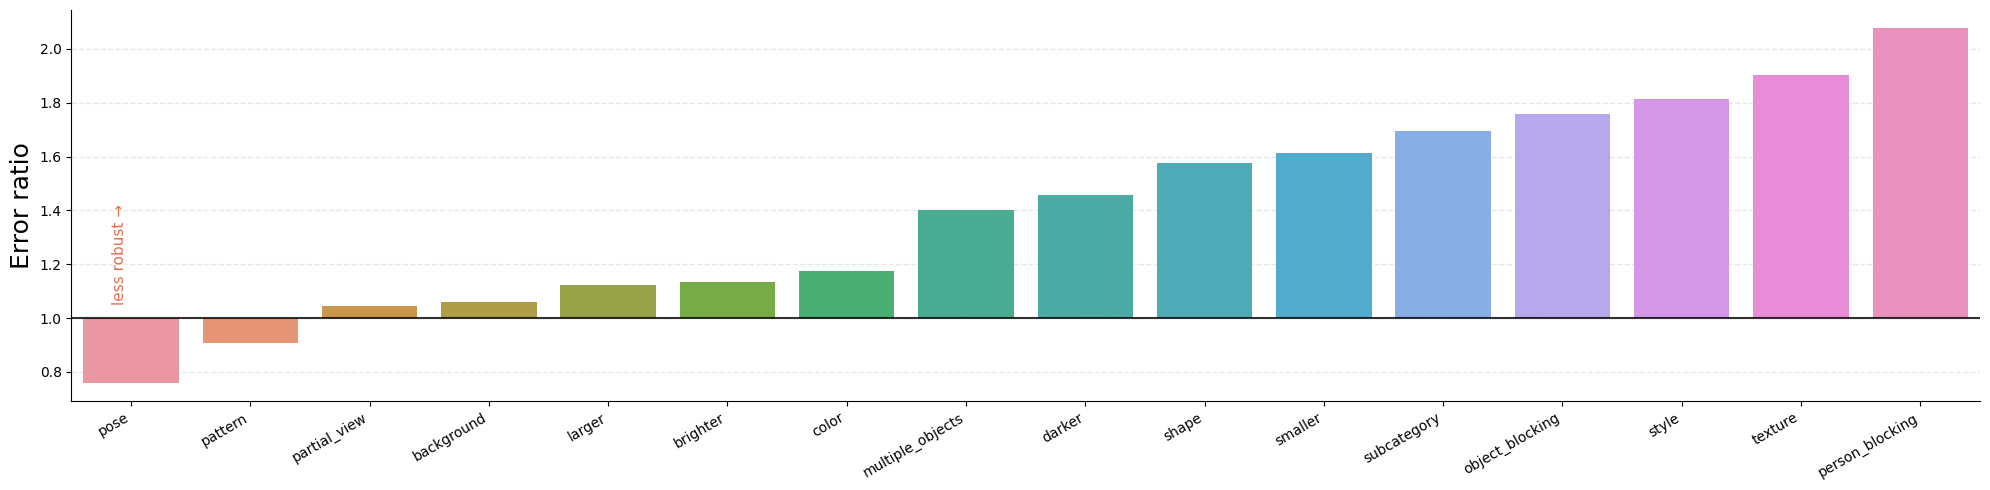

In [46]:
       
# Compute accuracies per factor
factor_accs = (correct/total).cpu().detach().numpy()
results = pd.DataFrame({'Factor': FACTORS, 'acc': factor_accs}).sort_values('acc', ascending=False)

# Compute error ratios per factor
results['Error ratio'] = (1 - results['acc']) / (1-(correct.sum()/total.sum()).item())

# Plot results
plots.plot_bar_plot(results, x='Factor', y='Error ratio')
plt.show()
plt.savefig(modelname+'_error_ratio.png')